In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import xgboost as xgb

In [15]:
# Reading the data
df = pd.read_csv("../data/combined_data.csv", )

# Rename columns for Prophet
df = df.drop(["NO1", "NO3", "NO4", "NO5"], axis=1)

# rename Unnamed: 0 to Date
df = df.rename(columns={"Unnamed: 0": "Date", "NO2": "y"})

# Set date to datetime format
df["Date"] = pd.to_datetime(df["Date"])

df.head()

,Date,"('air_temperature', 'SN50480:0')","('air_temperature', 'SN50539:0')","('air_temperature', 'SN50540:0')","('air_temperature', 'SN51530:0')","('sum(precipitation_amount P1D)', 'SN50480:0')","('sum(precipitation_amount P1D)', 'SN50539:0')","('sum(precipitation_amount P1D)', 'SN50540:0')","('sum(precipitation_amount P1D)', 'SN51530:0')","('sum(precipitation_amount P1D)', 'SN53160:0')","('wind_speed', 'SN50540:0')","('wind_speed', 'SN51530:0')",y
0,2016-01-01 00:00:00,NaN,NaN,7.7,6.2,0.920833,NaN,0.7,0.135417,0.033333,8.3,1.6,NaN
1,2016-01-01 01:00:00,NaN,NaN,8.1,8.2,0.920833,NaN,0.7,0.135417,0.033333,8.3,3.7,NaN
2,2016-01-01 02:00:00,NaN,NaN,8.7,8.0,0.920833,NaN,0.7,0.135417,0.033333,13.7,4.0,NaN
3,2016-01-01 03:00:00,NaN,NaN,8.7,7.8,0.920833,NaN,0.7,0.135417,0.033333,9.3,5.6,NaN
4,2016-01-01 04:00:00,NaN,NaN,5.2,8.1,0.920833,NaN,0.7,0.135417,0.033333,6.8,3.1,NaN


In [16]:

# # Create a new figure for plotting
# plt.figure(figsize=(15, 12))

# # Sliding window validation
# for i, (train_index, test_index) in enumerate(tscv.split(df)):
#     train = df.iloc[train_index]
#     test = df.iloc[test_index]
    
#     if len(test) > 24:  # We only want to forecast 24 hours into the future
#         test = test[:24]
    
#     # Using Prophet
#     model = Prophet(daily_seasonality=True)
#     model.fit(train)
    
#     future = model.make_future_dataframe(periods=24, freq='H') # Assuming hourly data, adjust the frequency if needed
#     forecast = model.predict(future)
    
#     # Only get the yhat predictions for the test set
#     predictions = forecast['yhat'][-24:].values

#     error = mean_absolute_error(test['y'], predictions)
    
#     # Plotting
#     plt.subplot(5, 1, i+1)  # 5 subplots for the 5 folds
#     plt.plot(test['ds'], test['y'], label='Actual')
#     plt.plot(test['ds'], predictions, label='Predicted', linestyle='--')
#     plt.title(f"Fold {i+1} - Mean Absolute Error: {error:.4f}")
#     plt.legend()

# plt.tight_layout()
# plt.show()

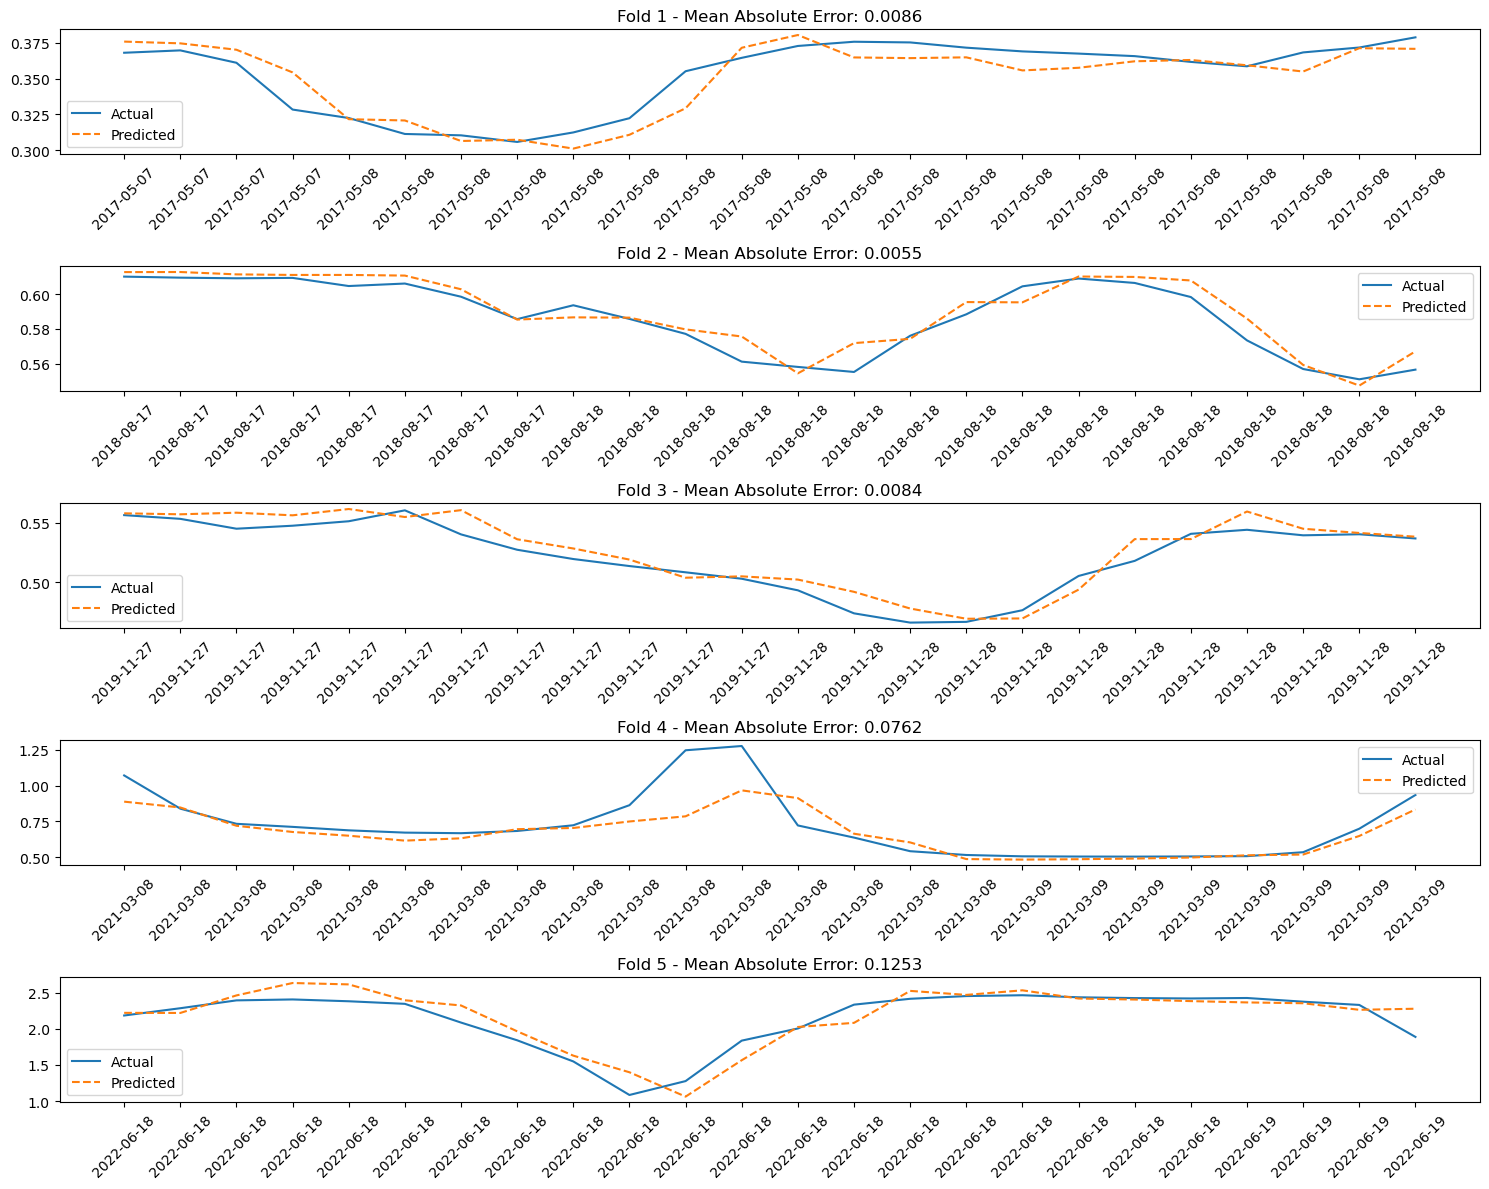

In [17]:
# We'll use lag features for time series with XGBoost, let's create some
for i in range(1, 25):  # 24 lags for hourly data
    df[f"lag_{i}"] = df["y"].shift(i)

# df.dropna(inplace=True)
# Drop NA in NO2 column
df = df.dropna(subset=["y"])


# Define the time series split object
tscv = TimeSeriesSplit(n_splits=5)

# Create a new figure for plotting
plt.figure(figsize=(15, 12))

# Sliding window validation
for i, (train_index, test_index) in enumerate(tscv.split(df)):
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    if len(test) > 24:  # We only want to forecast 24 hours into the future
        test = test[:24]
    
    # Using XGBoost
    model = xgb.XGBRegressor(objective="reg:squarederror")
    model.fit(train.drop(columns=["y", "Date"]), train["y"])
    
    predictions = model.predict(test.drop(columns=["y", "Date"]))

    error = mean_absolute_error(test['y'], predictions)
    
    # Plotting
    plt.subplot(5, 1, i+1)  # 5 subplots for the 5 folds
    plt.plot(test['Date'], test['y'], label='Actual')
    plt.plot(test['Date'], predictions, label='Predicted', linestyle='--')
    # set full datetime to xticks every 6 hours
    plt.xticks(test['Date'])
    plt.xticks(rotation=45)
    plt.title(f"Fold {i+1} - Mean Absolute Error: {error:.4f}")
    plt.legend()

plt.tight_layout()
plt.show()